# Find eigenvalues of the K matrices for varying PDE parameter "a"

In [1]:
# import all modules
# Third-party
import numpy as np
import torch

# Local files
import utilities
import train_NN as train
import neural_network as net

# Choose a device to run on - either CPU or GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# True PDE - Network will satify this PDE at the end of training
def pde_fn(x, a):
    # PDE: u_xx = -(pi*a)^2.sin(pi*a*x)
    u_xx = -(np.pi * a)**2 * np.sin(np.pi * a * x)
    return u_xx

# True solution - Network will try to learn this
def u(x, a):
    return np.sin(np.pi * a * x)

In [3]:
def create_1D_training_data(a, no_of_data_samples=100):
    dom_coords = np.array([[0.0],
                        [1.0]])
    X_bc1 = dom_coords[0, 0] * np.ones((no_of_data_samples // 2, 1))
    X_bc2 = dom_coords[1, 0] * np.ones((no_of_data_samples // 2, 1))

    X_u = np.vstack([X_bc1, X_bc2]) # data for BC
    Y_u = u(X_u, a) # y data for BC

    X_r = np.linspace(dom_coords[0, 0],
                    dom_coords[1, 0], no_of_data_samples)[:, None] # data for residual
    Y_r = pde_fn(X_r, a) # y data for residual
    return (X_u, Y_u, X_r, Y_r)  

In [4]:
import os

a_values_to_test = [1, 100]
seed = 1
data_directory = "./data_ntk/"
width = 500
depth = 2
max_itr = 10
save_data_freq = 5
save_eigenvalues_only = True

for avalue in a_values_to_test:
    # make a sub-directory for saving results of each "a" value
    save_data_location = data_directory+"a_{}".format(avalue)
    if not os.path.exists(save_data_location):        
        os.mkdir(save_data_location)
    # Create traning data for the given "a"
    train_data = create_1D_training_data(avalue)
    # Create model
    X_r = train_data[2]
    mean = X_r.mean(axis=0)  # (1, dim) values
    std = X_r.std(axis=0)  # (1, dim) values  
    # Create network
    model = net.PINN(no_of_neurons=width,
                     no_of_h_layers=depth,
                     seed=seed,
                     mean= mean.item(), std =std.item())
    model.to(device)
    details = train.train_nn_model(model, train_data=train_data,
                                no_iterations=max_itr, device=device,
                                save_data_location=save_data_location,
                                save_data_frequency=save_data_freq,
                                save_eigs_only=save_eigenvalues_only)
    del model

## Calculate the eigenvalues

In [6]:
import utilities
eig_vals = np.load("./data_ntk/a_100/eigenvalues_itr_0.npz")
eig_vals.files

['eig_uu', 'eig_rr', 'eig_K']

In [7]:
eig_uu = eig_vals['eig_uu']
eig_rr = eig_vals['eig_rr']
eig_K = eig_vals['eig_K']

Text(0.5, 0.98, 'a=100_itr_0')

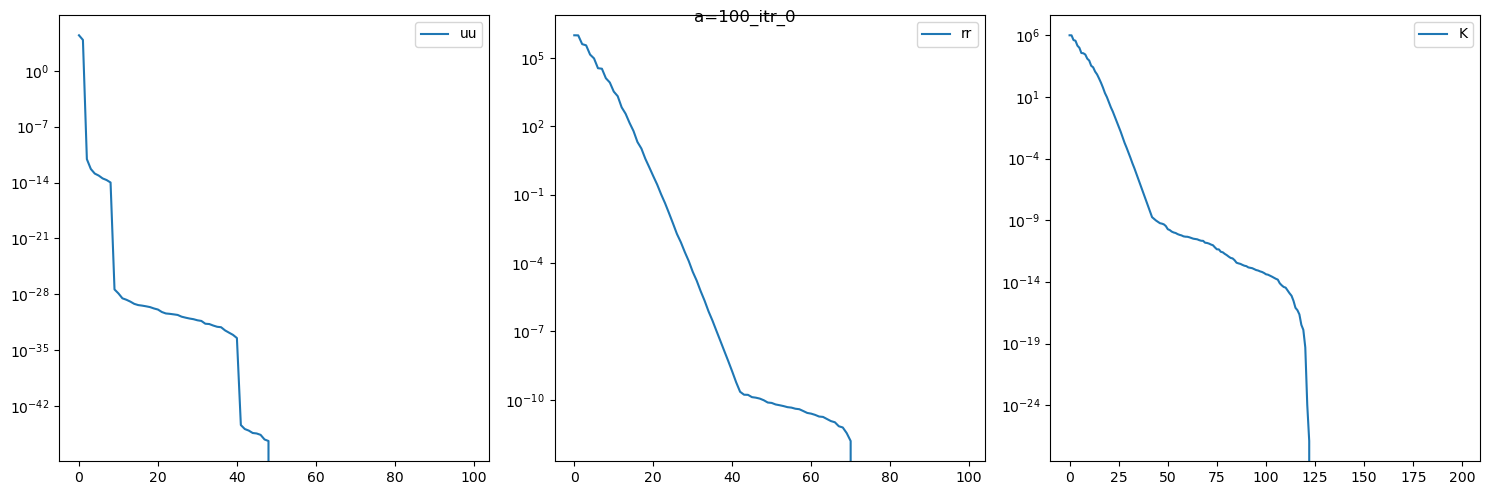

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3, figsize= (15,5))
ax[0].semilogy(eig_uu, label ='uu')
ax[0].legend()
ax[1].semilogy(eig_rr, label = 'rr')
ax[1].legend()
ax[2].semilogy(eig_K, label = 'K')
ax[2].legend()
plt.tight_layout()
plt.suptitle("a=100_itr_0")